<a href="https://colab.research.google.com/github/sumner-harris/Gomb-Net/blob/main/Measure_Graphene_Lattice_Parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring the lattice parameter and C-C bond distance  in graphene

Sumner B. Harris

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/AustinHouston/Gomb-Net/blob/main/Eval_Graphene_model.ipynb)

In [1]:
# basics
import os
import sys
import numpy as np

# plotting
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm

# colab interactive plots and drive
drive = False
if 'google.colab' in sys.modules:
    from  google.colab import drive
    from google.colab import output
    drive.mount('/content/drive')
    output.enable_custom_widget_manager()
    drive = True
else:
    %matplotlib widget

# other imports
from scipy.ndimage import label, center_of_mass, gaussian_filter, zoom, uniform_filter
from scipy.spatial import KDTree
from scipy.interpolate import griddata
from scipy.stats import norm, gaussian_kde
from skimage.filters import threshold_otsu
from skimage.feature import blob_log

# for cropping function
if drive:
    print('installing DataGenSTEM')
    !pip install ase
    !git clone https://github.com/ahoust17/DataGenSTEM.git
    sys.path.append('./DataGenSTEM/DataGenSTEM')
    import data_generator as dg

# for Gomb-Net
if drive:
    print('installing Gomb-Net')
    !git clone https://github.com/ahoust17/Gomb-Net.git
    sys.path.append('./Gomb-Net/')
from GombNet.networks import *
from GombNet.loss_func import GombinatorialLoss
from GombNet.utils import *

import torch
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
installing DataGenSTEM
fatal: destination path 'DataGenSTEM' already exists and is not an empty directory.
installing Gomb-Net
fatal: destination path 'Gomb-Net' already exists and is not an empty directory.
CUDA is not available. Using CPU.


### Now, you need to add the following shared drive to your google drive:
*** WARNING: it is a big file.  Check before you download ***


https://drive.google.com/file/d/1DyKtrmJ8wNYQg3YEJ8_iXjz6lB_DQfwy/view?usp=sharing

### Run the following cell after the download is complete

In [2]:
# should be someting like 'content/drive/My Drive/Gomb-Net files'
if drive:
    shared_folder = 'drive/My Drive/Gomb-Net files'
else:
    shared_folder = '/Users/austin/Desktop/gomb_beta'

print('available files & directories:')
!ls '{shared_folder}'

available files & directories:
 Experimental_datasets	   Graphene_dataset    WSSe_dataset
'Gomb-Net aux files.zip'   Pretrained_models


### Now, on to running the code

let's look at the dataset:

In [3]:
# Create dataloaders
images_dir = str(shared_folder + '/Graphene_dataset/images')
labels_dir = str(shared_folder + '/Graphene_dataset/labels')
train_loader, val_loader, test_loader = get_dataloaders(images_dir, labels_dir, batch_size = 1, val_split=0.2, test_split=0.1, seed = 42)


Train size: 700, Validation size: 200, Test size: 100


In [4]:
# Initialize model
input_channels = 1
num_classes = 2
num_filters = [32, 64, 128, 256]

model = TwoLeggedUnet(input_channels, num_classes, num_filters, dropout = 0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = GombinatorialLoss(group_size = num_classes//2, loss = 'Dice', epsilon=1e-6, class_weights = None, alpha=2)

load in the pretrained weights onto our model 'skeleton'

In [5]:
model_path = str(shared_folder + '/Pretrained_models/Graphene_model.pth')

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

TwoLeggedUnet(
  (encoders): ModuleDict(
    (encoder_0): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (encoder_1): EncoderBlock(
      (conv_block): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_

### Now, on Experimental data:

Pixel size: 1.062231596676198e-11 m/pix


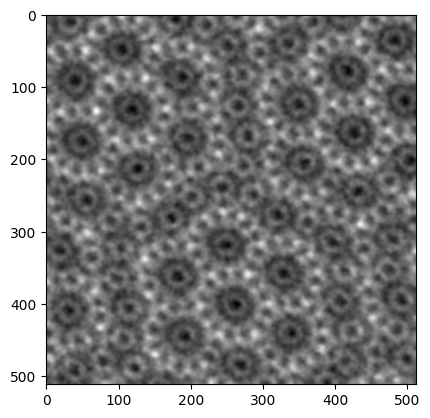

In [6]:
exp_data = np.load(str(shared_folder + '/Experimental_datasets/moire.npz'))
im_array = exp_data['im_array']
pixel_size = exp_data['pixel_size']

from scipy.ndimage import gaussian_filter

# im_array = gaussian_filter(im_array, sigma=1)
im_array = im_array - np.min(im_array)
im_array = im_array / np.max(im_array)
im_array = gaussian_filter(im_array, sigma=2.0)

print(f"Pixel size: {pixel_size.astype(float)} m/pix")
plt.figure()
plt.imshow(im_array, cmap='gray')

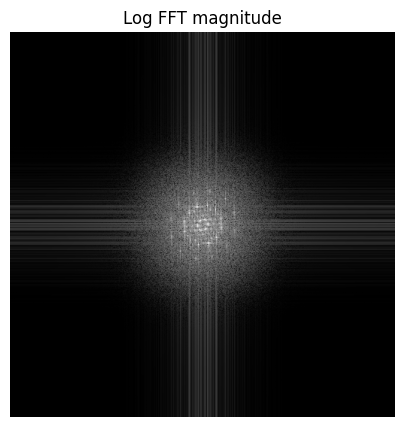

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 2D FFT and shift so zero‐frequency is at center
F = np.fft.fftshift(np.fft.fft2(im_array))
mag = np.abs(F)

r1,r2 = 1,500
yy, xx = np.indices(mag.shape)
cy, cx = np.array(mag.shape) / 2
r = np.hypot(xx - cx, yy - cy)
mag = mag * ((r >= r1) & (r <= r2))

# display
plt.figure(figsize=(5,5))
plt.imshow(np.log1p(mag), cmap='gray')
plt.title('Log FFT magnitude')
plt.axis('off')
plt.show()


# Find the lattice constant from the first order spots
r1,r2 = 20,35

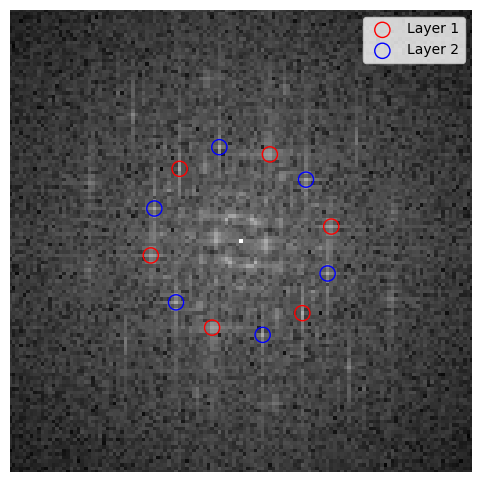

Layer 1: a = 2.452 Å, C–C = 1.416 Å, φ = 9.09°
Layer 2: a = 2.447 Å, C–C = 1.413 Å, φ = 43.36°
Twist angle between layers = 25.73°


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

# --- 1) Compute FFT and band‐pass filter around your 2nd‐order ring ---
F   = np.fft.fftshift(np.fft.fft2(im_array))
mag = np.abs(F)
mag0 = np.log1p(mag)
#mag = gaussian_filter(mag, sigma=1.5)

r1, r2 = 20, 35  # your band‐pass limits in px
yy, xx = np.indices(mag.shape)
cy, cx = np.array(mag.shape) / 2
r      = np.hypot(xx - cx, yy - cy)
mag    = mag * ((r >= r1) & (r <= r2))

# --- 2) Log‐scale for peak finding ---
img = np.log1p(mag)

# --- 3) Detect up to 12 Bragg spots ---
coords = peak_local_max(img,
                        min_distance=8,
                        threshold_rel=0.1,
                        num_peaks=12)

# --- 4) Compute each spot’s radius & angle from center ---
dy_spots     = coords[:,0] - cy
dx_spots     = coords[:,1] - cx
r_spots      = np.hypot(dx_spots, dy_spots)
theta_spots  = (np.degrees(np.arctan2(dy_spots, dx_spots)) + 360) % 360

# --- 5) Sort by angle and assign alternating layers ---
order       = np.argsort(theta_spots)
layer1_idx  = order[0::2]
layer2_idx  = order[1::2]

# --- 6) Plot FFT with red/blue circles for each layer ---
plt.figure(figsize=(6,6))
plt.imshow(mag0, cmap='gray')
plt.scatter(coords[layer1_idx,1], coords[layer1_idx,0],
            facecolors='none', edgecolors='r', s=120, label='Layer 1')
plt.scatter(coords[layer2_idx,1], coords[layer2_idx,0],
            facecolors='none', edgecolors='b', s=120, label='Layer 2')
plt.legend(loc='upper right')
plt.axis('off')
plt.xlim(192,320)
plt.ylim(192,320)
plt.show()

# --- 7) Compute lattice parameters from each layer (2nd‐order ring) ---
px = float(pixel_size) * 1e10     # Å/pix
N  = im_array.shape[0]            # image dimension

a1 = 2/np.sqrt(3) * N * px/ r_spots[layer1_idx]
a2 = 2/np.sqrt(3) * N * px/ r_spots[layer2_idx]
d1 = a1 / np.sqrt(3)
d2 = a2 / np.sqrt(3)

a1_mean = np.mean(a1)
a2_mean = np.mean(a2)
d1_mean = np.mean(d1)
d2_mean = np.mean(d2)

# --- 8) Compute twist angle between layers ---
phi1 = np.min(theta_spots[layer1_idx]) % 60
phi2 = np.min(theta_spots[layer2_idx]) % 60
delta = (phi2 - phi1 + 30) % 60 - 30
twist = abs(delta)

# --- 9) Report results ---
print(f"Layer 1: a = {a1_mean:.3f} Å, C–C = {d1_mean:.3f} Å, φ = {phi1:.2f}°")
print(f"Layer 2: a = {a2_mean:.3f} Å, C–C = {d2_mean:.3f} Å, φ = {phi2:.2f}°")
print(f"Twist angle between layers = {twist:.2f}°")


# Report the mean lattice parameter and C-C bond distance with standard devation

In [9]:
a = 2/np.sqrt(3) * N * px/ r_spots
d = a / np.sqrt(3)

a_mean, a_std, d_mean, d_std = a.mean(), a.std(), d.mean(), d.std()

print(f"Average a = {a_mean:.2f} +/- {a_std:.2f} Å, C–C = {d_mean:.2f} +/- {d_std:.2f} Å Å")

Average a = 2.45 +/- 0.06 Å, C–C = 1.41 +/- 0.04 Å Å


# Find the lattice constant from the 2nd order spots

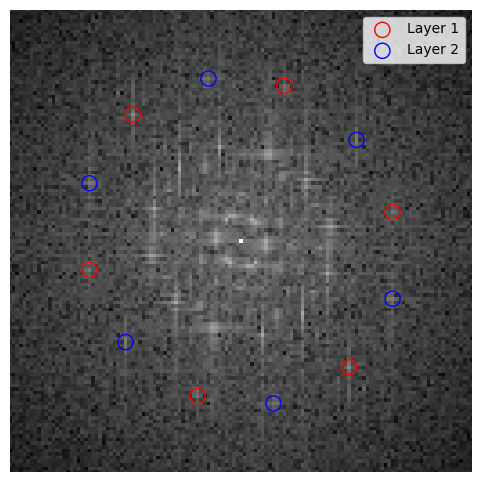

Layer 1: a = 2.447 Å, C–C = 1.413 Å, φ = 10.78°
Layer 2: a = 2.449 Å, C–C = 1.414 Å, φ = 41.19°
Twist angle between layers = 29.60°


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

# --- 1) Compute FFT and band‐pass filter around your 2nd‐order ring ---
F   = np.fft.fftshift(np.fft.fft2(im_array))
mag = np.abs(F)
mag0 = np.log1p(mag)
#mag = gaussian_filter(mag, sigma=1.5)

r1, r2 = 38, 60   # your band‐pass limits in px
yy, xx = np.indices(mag.shape)
cy, cx = np.array(mag.shape) / 2
r      = np.hypot(xx - cx, yy - cy)
mag    = mag * ((r >= r1) & (r <= r2))

# --- 2) Log‐scale for peak finding ---
img = np.log1p(mag)

# --- 3) Detect up to 12 Bragg spots ---
coords = peak_local_max(img,
                        min_distance=8,
                        threshold_rel=0.1,
                        num_peaks=12)

# --- 4) Compute each spot’s radius & angle from center ---
dy_spots     = coords[:,0] - cy
dx_spots     = coords[:,1] - cx
r_spots      = np.hypot(dx_spots, dy_spots)
theta_spots  = (np.degrees(np.arctan2(dy_spots, dx_spots)) + 360) % 360

# --- 5) Sort by angle and assign alternating layers ---
order       = np.argsort(theta_spots)
layer1_idx  = order[0::2]
layer2_idx  = order[1::2]

# --- 6) Plot FFT with red/blue circles for each layer ---
plt.figure(figsize=(6,6))
plt.imshow(mag0, cmap='gray')
plt.scatter(coords[layer1_idx,1], coords[layer1_idx,0],
            facecolors='none', edgecolors='r', s=120, label='Layer 1')
plt.scatter(coords[layer2_idx,1], coords[layer2_idx,0],
            facecolors='none', edgecolors='b', s=120, label='Layer 2')
plt.legend(loc='upper right')
plt.axis('off')
plt.xlim(192,320)
plt.ylim(192,320)
plt.show()

# --- 7) Compute lattice parameters from each layer (2nd‐order ring) ---
px = float(pixel_size) * 1e10     # Å/pix
N  = im_array.shape[0]           # image dimension

a1 = 2* N * px/ r_spots[layer1_idx]
a2 = 2* N * px/ r_spots[layer2_idx]
d1 = a1 / np.sqrt(3)
d2 = a2 / np.sqrt(3)

a1_mean = np.mean(a1)
a2_mean = np.mean(a2)
d1_mean = np.mean(d1)
d2_mean = np.mean(d2)

# --- 8) Compute twist angle between layers ---
phi1 = np.min(theta_spots[layer1_idx]) % 60
phi2 = np.min(theta_spots[layer2_idx]) % 60
delta = (phi2 - phi1 + 30) % 60 - 30
twist = abs(delta)

# --- 9) Report results ---
print(f"Layer 1: a = {a1_mean:.3f} Å, C–C = {d1_mean:.3f} Å, φ = {phi1:.2f}°")
print(f"Layer 2: a = {a2_mean:.3f} Å, C–C = {d2_mean:.3f} Å, φ = {phi2:.2f}°")
print(f"Twist angle between layers = {twist:.2f}°")


# Report the mean lattice parameter and C-C bond distance with standard devation

In [11]:
a_2 = 2 * N * px/ r_spots
d_2 = a / np.sqrt(3)

a_2_mean, a_2_std, d_2_mean, d_2_std = a.mean(), a_2.std(), d_2.mean(), d_2.std()

print(f"Average a = {a_2_mean:.2f} +/- {a_2_std:.2f} Å, C–C = {d_2_mean:.2f} +/- {d_2_std:.2f} Å Å")

Average a = 2.45 +/- 0.08 Å, C–C = 1.41 +/- 0.04 Å Å


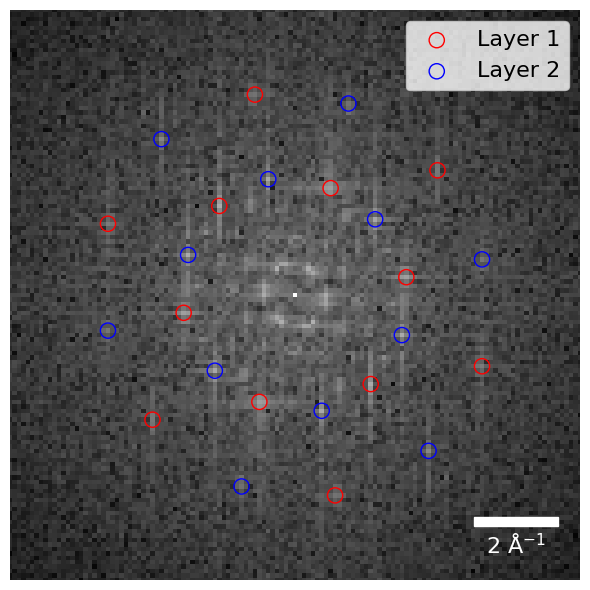

In [13]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
F   = np.fft.fftshift(np.fft.fft2(im_array))
mag = np.abs(F)
mag0 = np.log1p(mag)

r1, r2 = 20, 35  # your band‐pass limits in px
yy, xx = np.indices(mag.shape)
cy, cx = np.array(mag.shape) / 2
r      = np.hypot(xx - cx, yy - cy)
mag    = mag * ((r >= r1) & (r <= r2))

img = np.log1p(mag)

coords = peak_local_max(img,
                        min_distance=8,
                        threshold_rel=0.1,
                        num_peaks=12)

dy_spots     = coords[:,0] - cy
dx_spots     = coords[:,1] - cx
r_spots      = np.hypot(dx_spots, dy_spots)
theta_spots  = (np.degrees(np.arctan2(dy_spots, dx_spots)) + 360) % 360

order       = np.argsort(theta_spots)
layer1_idx  = order[0::2]
layer2_idx  = order[1::2]

F   = np.fft.fftshift(np.fft.fft2(im_array))
mag = np.abs(F)
mag0 = np.log1p(mag)

r1, r2 = 38, 60   # your band‐pass limits in px
yy, xx = np.indices(mag.shape)
cy, cx = np.array(mag.shape) / 2
r      = np.hypot(xx - cx, yy - cy)
mag    = mag * ((r >= r1) & (r <= r2))

img = np.log1p(mag)

coords2 = peak_local_max(img,
                        min_distance=8,
                        threshold_rel=0.1,
                        num_peaks=12)

dy_spots     = coords2[:,0] - cy
dx_spots     = coords2[:,1] - cx
r_spots      = np.hypot(dx_spots, dy_spots)
theta_spots  = (np.degrees(np.arctan2(dy_spots, dx_spots)) + 360) % 360

order       = np.argsort(theta_spots)
layer1_idx2  = order[0::2]
layer2_idx2  = order[1::2]


plt.figure(figsize=(6,6))
plt.imshow(mag0, cmap='gray')
plt.scatter(coords[layer1_idx,1], coords[layer1_idx,0],
            facecolors='none', edgecolors='r', s=120, label='Layer 1')
plt.scatter(coords[layer2_idx,1], coords[layer2_idx,0],
            facecolors='none', edgecolors='b', s=120, label='Layer 2')
plt.scatter(coords2[layer1_idx2,1], coords2[layer1_idx2,0],
            facecolors='none', edgecolors='b', s=120)
plt.scatter(coords2[layer2_idx2,1], coords2[layer2_idx2,0],
            facecolors='none', edgecolors='r', s=120)

plt.legend(loc='upper right',fontsize=16)
plt.axis('off')
plt.xlim(192,320)
plt.ylim(192,320)


# Create and add scalebar to the plot
scalebar = AnchoredSizeBar(plt.gca().transData,
                           2/px,
                           '2 Å$^{-1}$',
                           'lower right',
                           borderpad=0.5,
                           pad= 0.5,
                           sep = 5,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties={'size': 16})

plt.gca().add_artist(scalebar)
plt.tight_layout()
plt.savefig('graphene FFT.png', dpi=600, transparent=True)
plt.show()

# Report the mean lattice parameter and C-C bond distance with standard devation considering all 24 spots

In [14]:
A = np.concat((a,a_2))
D = np.concat((d,d_2))

A_mean, A_std, D_mean, D_std = A.mean(), A.std(), D.mean(), D.std()

print(f"Average a = {A_mean:.2f} +/- {A_std:.2f} Å, C–C = {D_mean:.2f} +/- {D_std:.2f} Å Å")

Average a = 2.45 +/- 0.07 Å, C–C = 1.41 +/- 0.04 Å Å
